In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 of58uq12


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-of58uq12:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/330 [00:01<05:42,  1.04s/it]

  2%|██▋                                                                                                                                                 | 6/330 [00:01<00:48,  6.74it/s]

  3%|████▉                                                                                                                                              | 11/330 [00:01<00:25, 12.71it/s]

  5%|███████▏                                                                                                                                           | 16/330 [00:01<00:16, 18.50it/s]

  6%|█████████▎                                                                                                                                         | 21/330 [00:01<00:12, 23.78it/s]

  8%|███████████▌                                                                                                                                       | 26/330 [00:01<00:10, 28.34it/s]

  9%|█████████████▊                                                                                                                                     | 31/330 [00:01<00:09, 32.07it/s]

 11%|████████████████                                                                                                                                   | 36/330 [00:01<00:08, 35.00it/s]

 12%|██████████████████▎                                                                                                                                | 41/330 [00:01<00:07, 37.25it/s]

 14%|████████████████████▍                                                                                                                              | 46/330 [00:02<00:07, 38.88it/s]

 15%|██████████████████████▋                                                                                                                            | 51/330 [00:02<00:06, 40.09it/s]

 17%|████████████████████████▉                                                                                                                          | 56/330 [00:02<00:06, 41.07it/s]

 18%|███████████████████████████▏                                                                                                                       | 61/330 [00:02<00:06, 41.79it/s]

 20%|█████████████████████████████▍                                                                                                                     | 66/330 [00:02<00:06, 42.30it/s]

 22%|███████████████████████████████▋                                                                                                                   | 71/330 [00:02<00:06, 42.68it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 76/330 [00:02<00:05, 42.68it/s]

 25%|████████████████████████████████████                                                                                                               | 81/330 [00:02<00:05, 42.85it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 86/330 [00:03<00:05, 43.05it/s]

 28%|████████████████████████████████████████▌                                                                                                          | 91/330 [00:03<00:05, 43.18it/s]

 29%|██████████████████████████████████████████▊                                                                                                        | 96/330 [00:03<00:05, 43.28it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 101/330 [00:03<00:05, 43.33it/s]

 32%|██████████████████████████████████████████████▉                                                                                                   | 106/330 [00:03<00:05, 43.32it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 111/330 [00:03<00:05, 43.33it/s]

 35%|███████████████████████████████████████████████████▎                                                                                              | 116/330 [00:03<00:04, 43.33it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 121/330 [00:03<00:04, 43.34it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                          | 126/330 [00:03<00:04, 43.32it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 131/330 [00:04<00:04, 43.33it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 136/330 [00:04<00:04, 43.34it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 141/330 [00:04<00:04, 43.31it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 146/330 [00:04<00:04, 43.27it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 151/330 [00:04<00:04, 43.28it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                             | 156/330 [00:04<00:04, 43.27it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 161/330 [00:04<00:03, 43.27it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 166/330 [00:04<00:03, 43.27it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 171/330 [00:04<00:03, 43.29it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 176/330 [00:05<00:03, 43.22it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 181/330 [00:05<00:03, 43.21it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 186/330 [00:05<00:03, 43.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 191/330 [00:05<00:03, 43.23it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 196/330 [00:05<00:03, 43.32it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 201/330 [00:05<00:02, 43.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 206/330 [00:05<00:02, 43.45it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 211/330 [00:05<00:02, 43.49it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 216/330 [00:06<00:02, 43.51it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 221/330 [00:06<00:02, 43.50it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 226/330 [00:06<00:02, 43.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 231/330 [00:06<00:02, 43.54it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 236/330 [00:06<00:02, 43.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 241/330 [00:06<00:02, 43.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 246/330 [00:06<00:01, 43.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 251/330 [00:06<00:01, 43.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 256/330 [00:06<00:01, 43.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 261/330 [00:07<00:01, 43.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 266/330 [00:07<00:01, 43.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 271/330 [00:07<00:01, 43.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 276/330 [00:07<00:01, 43.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 281/330 [00:07<00:01, 43.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 286/330 [00:07<00:01, 43.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 291/330 [00:07<00:00, 43.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 296/330 [00:07<00:00, 43.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 301/330 [00:07<00:00, 43.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 306/330 [00:08<00:00, 43.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 311/330 [00:08<00:00, 43.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 316/330 [00:08<00:00, 43.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 321/330 [00:08<00:00, 43.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 326/330 [00:08<00:00, 43.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:08<00:00, 38.10it/s]

train - OK


  0%|                                                                                                                                                             | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                 | 1/42 [00:00<00:05,  7.35it/s]

 14%|█████████████████████▎                                                                                                                               | 6/42 [00:00<00:01, 26.99it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 11/42 [00:00<00:00, 34.14it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 16/42 [00:00<00:00, 37.64it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 21/42 [00:00<00:00, 39.62it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26/42 [00:00<00:00, 40.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 31/42 [00:00<00:00, 41.62it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36/42 [00:00<00:00, 42.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:01<00:00, 42.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 36.63it/s]

val - OK


  0%|                                                                                                                                                             | 0/23 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                              | 1/23 [00:00<00:03,  6.75it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 6/23 [00:00<00:00, 25.89it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 11/23 [00:00<00:00, 33.28it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 16/23 [00:00<00:00, 36.95it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21/23 [00:00<00:00, 39.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.77it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                   | 1/138 [00:00<00:20,  6.54it/s]

  4%|██████▍                                                                                                                                             | 6/138 [00:00<00:05, 25.58it/s]

  8%|███████████▋                                                                                                                                       | 11/138 [00:00<00:03, 33.15it/s]

 12%|█████████████████                                                                                                                                  | 16/138 [00:00<00:03, 36.98it/s]

 15%|██████████████████████▎                                                                                                                            | 21/138 [00:00<00:02, 39.19it/s]

 19%|███████████████████████████▋                                                                                                                       | 26/138 [00:00<00:02, 40.55it/s]

 22%|█████████████████████████████████                                                                                                                  | 31/138 [00:00<00:02, 41.43it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 36/138 [00:00<00:02, 42.01it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 41/138 [00:01<00:02, 42.71it/s]

 33%|█████████████████████████████████████████████████                                                                                                  | 46/138 [00:01<00:02, 43.72it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 51/138 [00:01<00:01, 44.43it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 56/138 [00:01<00:01, 44.93it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 61/138 [00:01<00:01, 45.27it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 66/138 [00:01<00:01, 45.51it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 71/138 [00:01<00:01, 45.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/138 [00:01<00:01, 45.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 81/138 [00:01<00:01, 45.91it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86/138 [00:02<00:01, 45.96it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 91/138 [00:02<00:01, 46.00it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 96/138 [00:02<00:00, 46.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 101/138 [00:02<00:00, 46.07it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 106/138 [00:02<00:00, 46.05it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 111/138 [00:02<00:00, 46.08it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 116/138 [00:02<00:00, 46.10it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 121/138 [00:02<00:00, 46.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 126/138 [00:02<00:00, 46.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 131/138 [00:03<00:00, 46.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:03<00:00, 46.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 42.54it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:01, 48.08it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:01, 48.07it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 48.05it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 48.07it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 48.08it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 48.06it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 48.08it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 48.09it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:00<00:01, 48.10it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 48.09it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:00, 48.08it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 48.08it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 48.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 48.07it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 48.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 48.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 48.09it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:01<00:00, 48.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:01<00:00, 48.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.07it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928, 2) (2928,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568, 2) (17568,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


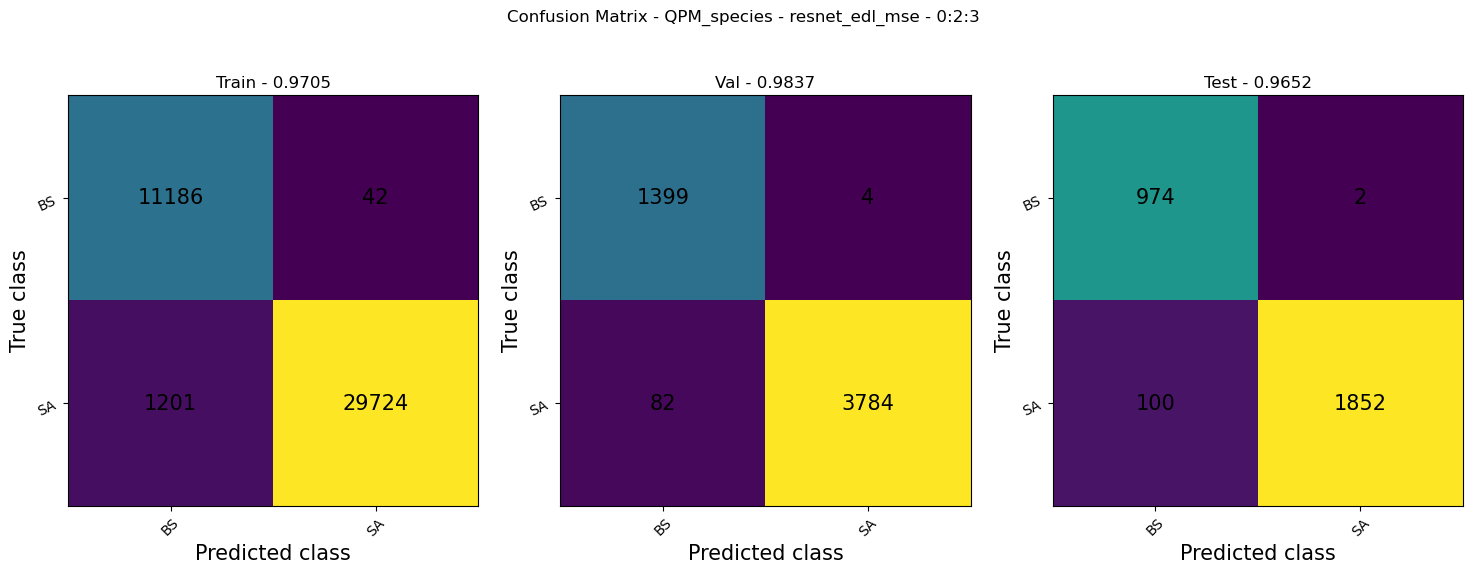

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


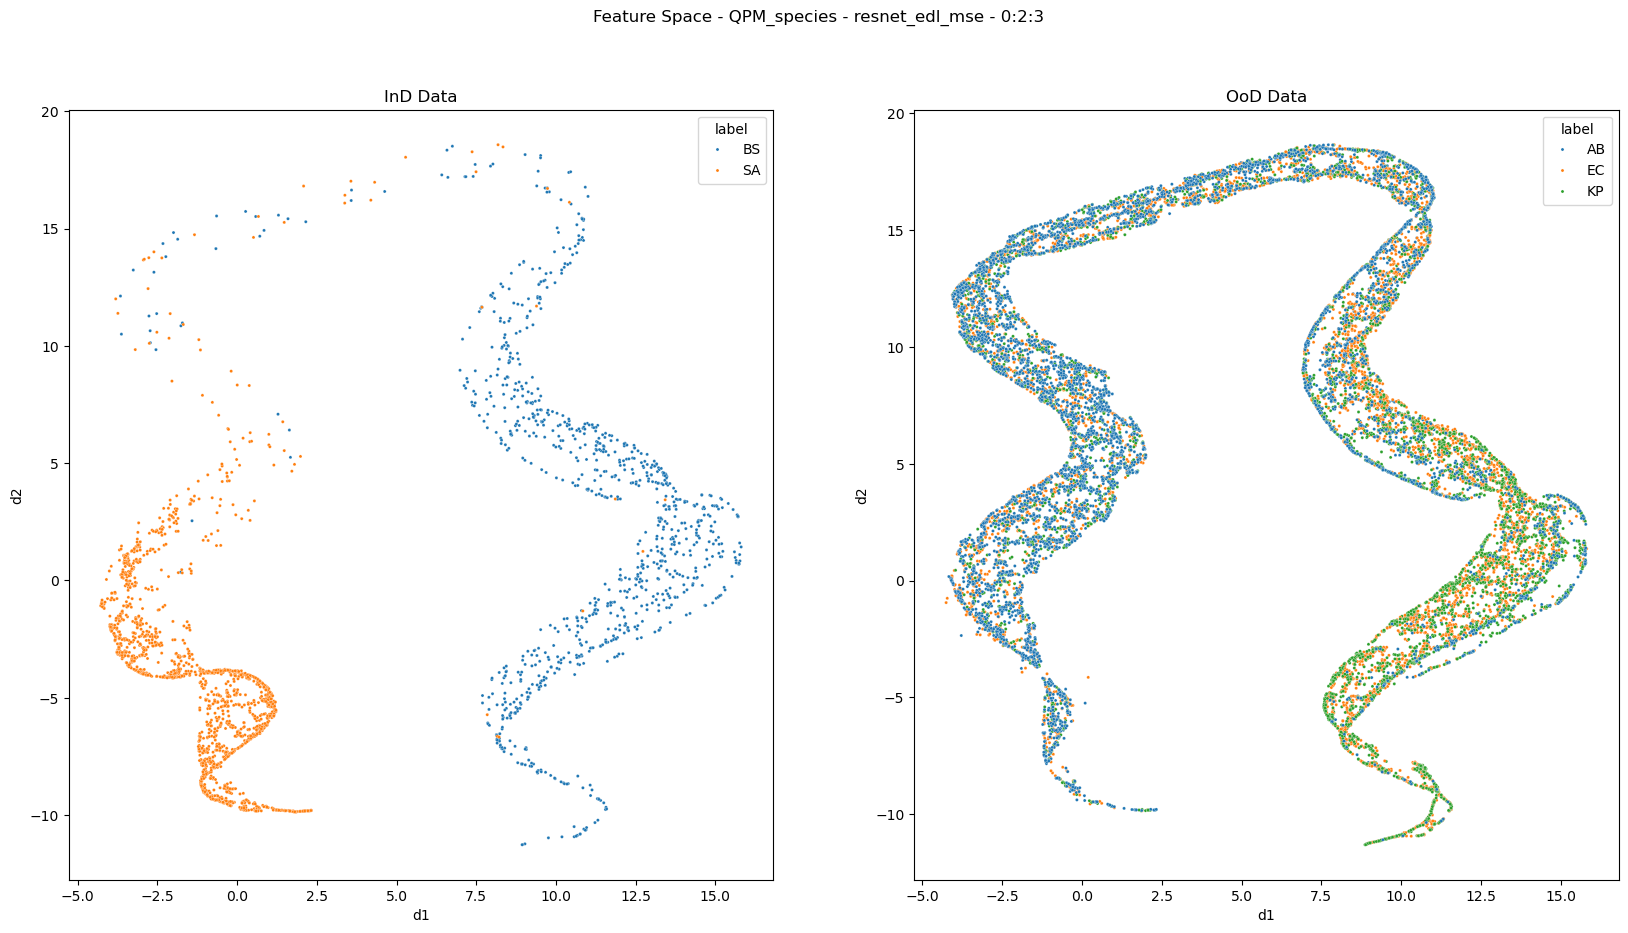

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

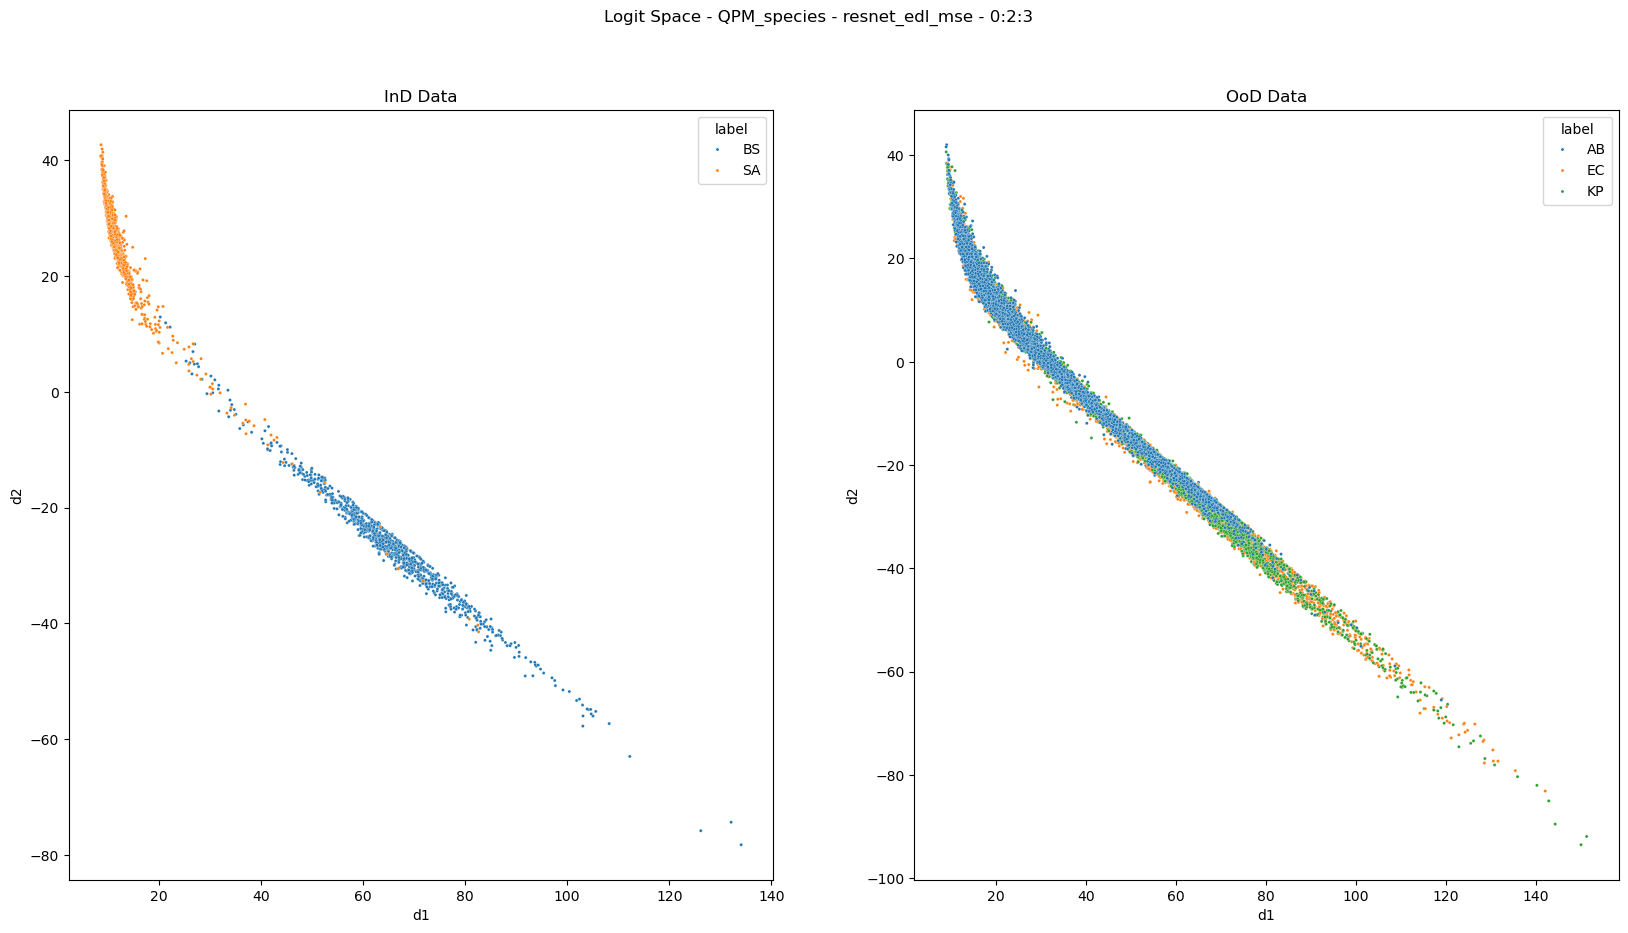

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

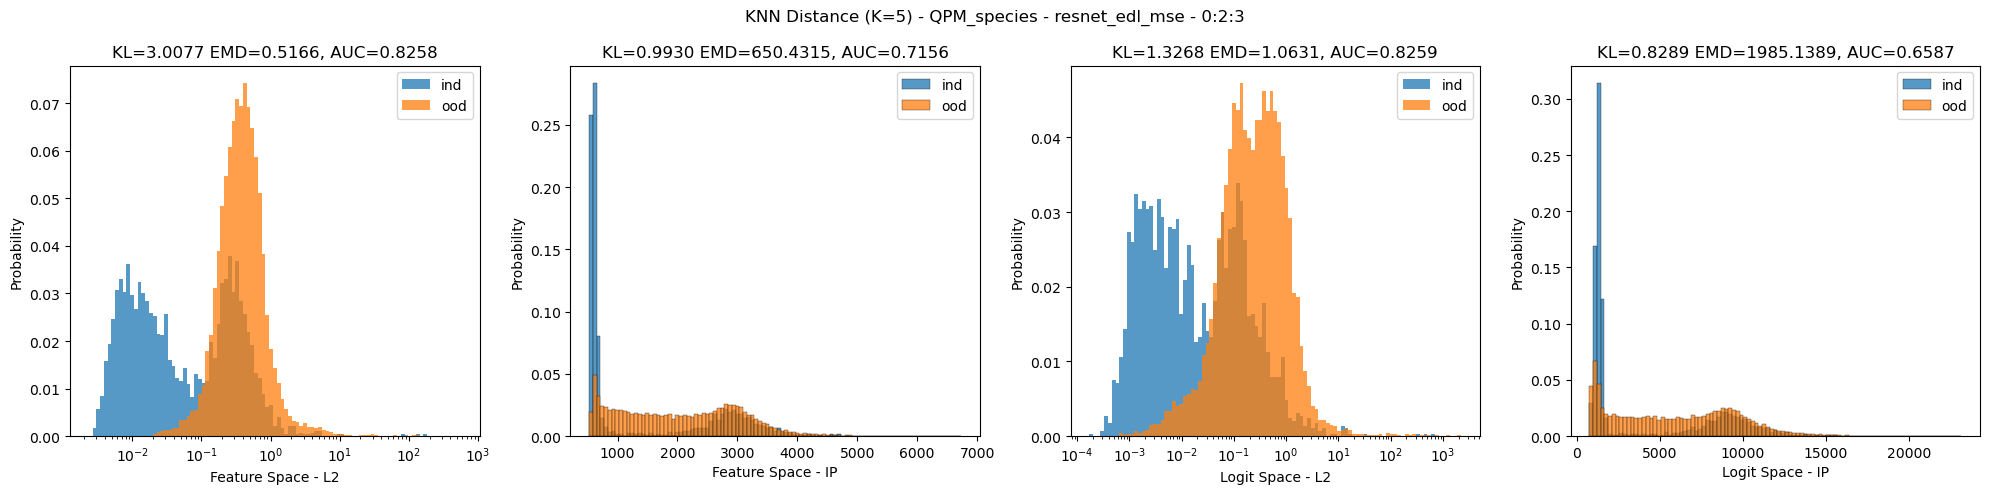

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

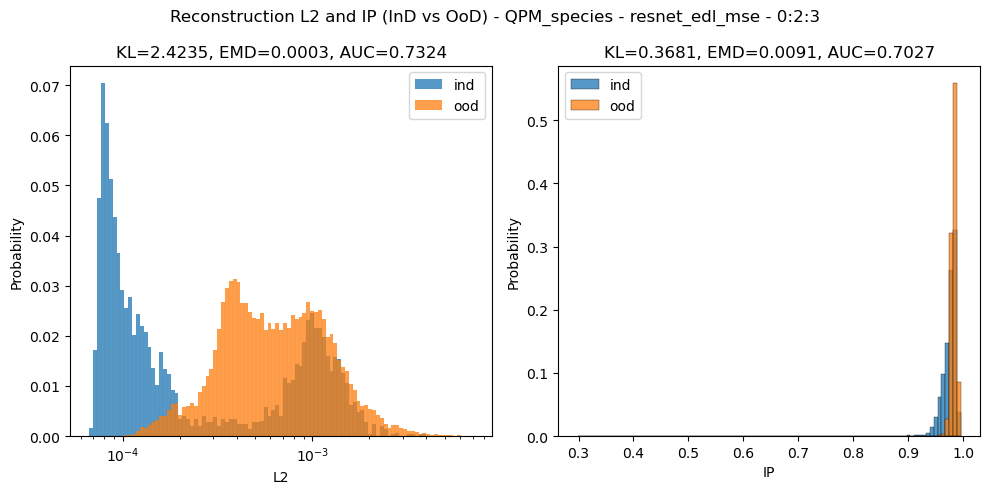

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

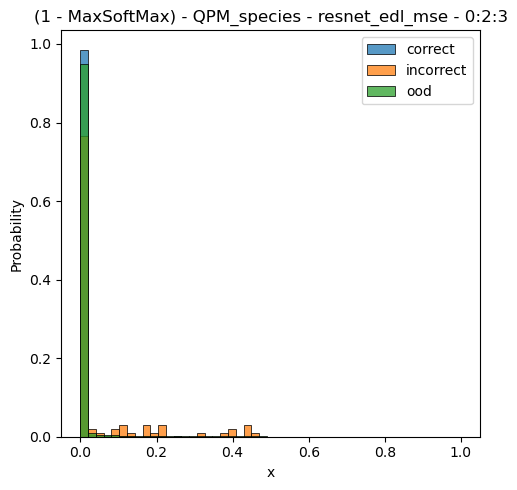

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

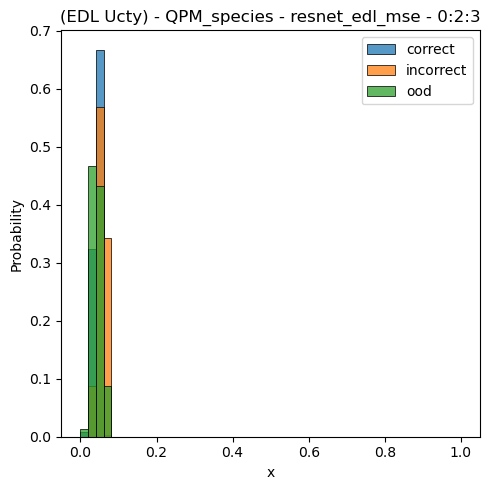

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [19]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)